<center><a target="_blank" href="https://www.womenplusplus.ch/deploy-impact/"><img src="https://drive.google.com/uc?id=1eOWdijaay1bv94PlIRMqNt7eWmUfAI2u" width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>

<center><a target="_blank" href="https://learning.sit.org/"><img src="https://drive.google.com/uc?id=1x9_jQgLhozCSWDSaOdVxKmxOEAe_OLgV" width="250" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Live Coding - Topic Modelling </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>SIT Learning, 2022</center>


# Topic Modeling on Research Papers

We will do an interesting exercise here—build topic models on past research papers
from the very popular NIPS conference (now known as the NeurIPS conference). The
late professor Sam Roweis compiled an excellent collection of NIPS Conference Papers
from Volume 1 – 12, which you can find at https://cs.nyu.edu/~roweis/data.html.
An interesting fact is that he obtained this by massaging the OCR’d data from NIPS
1-12, which was actually the pre-electronic submission era. Yann LeCun made the data
available. There is an even more updated dataset available up to NIPS 17 at http://
ai.stanford.edu/~gal/data.html. However, that dataset is in the form of a MAT file, so
you might need to do some additional preprocessing before working on it in Python.


# The Main Objective

Considering our discussion so far, our main objective is pretty simple. Given a whole
bunch of conference research papers, can we identify some key themes or topics from
these papers by leveraging unsupervised learning? We do not have the liberty of labeled
categories telling us what the major themes of every research paper are. Besides that, we
are dealing with text data extracted using OCR (optical character recognition). Hence,
you can expect misspelled words, words with characters missing, and so on, which
makes our problem even more challenging

# Download Data and Dependencies

In [53]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
!tar -xzf nips12raw_str602.tgz

--2022-10-26 16:18:32--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz.1’

nips12raw_str602.tg 100%[===================>]  12.26M  4.96MB/s    in 2.5s    

2022-10-26 16:18:35 (4.96 MB/s) - ‘nips12raw_str602.tgz.1’ saved [12851423/12851423]



In [54]:
!pip install tqdm
import nltk
nltk.download('punkt') # tokenization
nltk.download('stopwords')
nltk.download('wordnet') # lemmatization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips00', 'nips12', 'README_yann', 'nips01', 'MATLAB_NOTES', 'nips05', 'nips08', 'idx', 'nips09', 'nips07', 'RAW_DATA_NOTES', 'nips04', 'nips06', 'nips11', 'nips02', 'nips03', 'nips10', 'orig']


# Load NIPS Research Papers Data

In [56]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [57]:
len(papers)

1740

In [58]:
print(papers[3][:1000])

317 
PARTITIONING OF SENSORY DATA BY A COPTICAI, NETWOPK  
Richard Granger, Jos Ambros-Ingerson, Howard Henry, Gary Lynch 
Center for the Neurobiology of Learning and Memory 
University of California 
Irvine, CA, 91717 
ABSTRACT
To process sensory data, sensory brain areas must preserve information about both 
the similarities and differences among learned cues: without the latter, acuity would 
be lost, whereas without the former, degraded versions of a cue would be erroneously 
thought to be distinct cues, and would not be recognized. We have constructed a 
model of piriform cortex incorporating a large number of biophysical, anatomical and 
physiological parameters, such as two-step excitatory firing thresholds, necessary and 
suicient conditions for long-term potentiation (LTP) of synapses, three distinct types 
of inhibitory currents (short IPSPs, long hyperpolarizing currents (LHP) and long cell- 
specific afterhyperpolarization (AHP)), sparse connectivity between bulb and l

# Basic Text Pre-processing

We perform some basic text wrangling or preprocessing before diving into topic
modeling. We keep things simple here

In [59]:
%%time
import nltk # Natural Language Toolkit library
import tqdm # Fancy progress bar
nltk.download('omw-1.4')

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+') # can also use nltk.word_tokenize to get word tokens for each paper
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1] # removing any single character words \ numbers \ symbols 
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 1740/1740 [00:52<00:00, 32.85it/s]

1740
CPU times: user 42.2 s, sys: 842 ms, total: 43 s
Wall time: 53.2 s


In [60]:
print(norm_papers[0][:50])

['lti6h', 'density', 'associative', 'ories', 'ir', 'dembo', 'information', 'system', 'laboratory', 'stanford', 'university', 'stanford', 'ca', 'ofer', 'ze', 'itouni', 'laboratory', 'informat', 'ion', 'dec', 'ion', 'system', 'mit', 'cambridge', 'abstract', 'class', 'high', 'density', 'associative', 'memory', 'constr', 'cted', 'starting', 'description', 'de', 'ired', 'property', 'exhibit', 'property', 'include', 'high', 'capacity', 'oontrollable', 'basin', 'attraction', 'fast', 'speed', 'convergence', 'ortunately', 'enough']


# Build a Bi-gram Phrase Model

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms. We
leverage the very useful gensim.models.Phrases class for this. This capability helps us
automatically detect common phrases from a stream of sentences, which are typically
multi-word expressions/word n-grams. 

This implementation draws inspiration
from the famous paper by Mikolov, et al., “Distributed Representations of Words and
Phrases and their Compositionality,” which you can check out at https://arxiv.org/
abs/1310.4546. We start by extracting and generating words and bi-grams as phrases for
each tokenized research paper. 

We leverage the `min_count` parameter, which tells us that our model ignores all words and bi-grams with total
collected count lower than 20 across the corpus (of the input paper as a list of tokenized
sentences). We also use a `threshold` of 20, which tells us that the model accepts specific
phrases based on this threshold value so that a phrase of words `"a followed by b"` is
accepted if the score of the phrase is greater than the threshold of 20. This threshold is
dependent on the scoring parameter, which helps us understand how these phrases are
scored to understand their influence.
Typically the default scorer is used and it’s pretty straightforward to understand.
You can check out further details in the documentation at https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer and in the
previously mentioned research paper.

In [61]:
import gensim
gensim.__version__ # version 3.6 needed to run MALLET LDA models

'3.6.0'

In [62]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20) # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50]) # very similar to using ngram_range=(1,2) in count vectorizer

['lti6h', 'density', 'associative', 'ories', 'ir', 'dembo', 'information', 'system', 'laboratory', 'stanford_university', 'stanford_ca', 'ofer', 'ze', 'itouni', 'laboratory', 'informat', 'ion', 'dec', 'ion', 'system', 'mit', 'cambridge_abstract', 'class', 'high', 'density', 'associative_memory', 'constr', 'cted', 'starting', 'description', 'de', 'ired', 'property', 'exhibit', 'property', 'include', 'high', 'capacity', 'oontrollable', 'basin_attraction', 'fast', 'speed', 'convergence', 'ortunately', 'enough', 'resulting', 'memory', 'implementable', 'artificial_neural', 'net']


In [63]:
#bigram_model[norm_papers[-1][:10]]

In [64]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '0on'), (1, '0pn'), (2, '1an'), (3, '1coat'), (4, '2__'), (5, '2ai'), (6, '2f'), (7, '2m'), (8, '2r'), (9, '3a'), (10, '4a'), (11, '4b'), (12, '4c'), (13, '4d'), (14, '4e')]
Total Vocabulary Size: 78892


Looks like we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this. 

In [65]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6) # similar to min_df and max_df in count vectorizer
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


We removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 60% of all the documents. We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

# Transforming corpus into bag of words vectors

We can now perform feature engineering by leveraging a simple Bag of Words model. In BOW a text (such as a sentence or a document) is represented as the bag of its words, disregarding grammar and even word order but keeping multiplicity. 


In [66]:
# norm_corpus_bigrams[0][:10] 

In [67]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(9, 1), (21, 1), (22, 2), (24, 1), (31, 1), (39, 1), (47, 11), (51, 2), (53, 3), (65, 1), (70, 1), (71, 4), (74, 1), (80, 1), (81, 1), (89, 10), (97, 44), (101, 1), (108, 1), (111, 1), (138, 1), (143, 1), (150, 1), (154, 5), (175, 1), (178, 2), (180, 2), (187, 1), (215, 1), (222, 1), (240, 4), (249, 3), (252, 1), (257, 1), (260, 3), (266, 1), (268, 1), (269, 1), (274, 1), (279, 1), (285, 1), (286, 7), (287, 2), (293, 1), (296, 2), (297, 2), (309, 1), (312, 2), (316, 6), (317, 1)]


In [68]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('according', 1), ('always', 1), ('american_institute', 2), ('analyzed', 1), ('arbitrary', 1), ('assume', 1), ('behavior', 11), ('bound', 2), ('bounded', 3), ('change', 1), ('choose', 1), ('chosen', 4), ('clear', 1), ('comparison', 1), ('complete', 1), ('constant', 10), ('convergence', 44), ('corresponding', 1), ('defined', 1), ('denote', 1), ('easily', 1), ('el', 1), ('energy', 1), ('equation', 5), ('extremely', 1), ('fast', 2), ('fig', 2), ('follows', 1), ('include', 1), ('initial', 1), ('iteration', 4), ('le', 3), ('let', 1), ('linear', 1), ('location', 3), ('mainly', 1), ('measure', 1), ('memory', 1), ('mit', 1), ('natural', 1), ('neural', 1), ('neuron', 7), ('next', 2), ('note', 1), ('operation', 2), ('optimal', 2), ('particular', 1), ('physic', 2), ('position', 6), ('positive', 1)]


In [69]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


# Topic Models with Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) technique is a generative probabilistic model in
which each document is assumed to have a combination of topics similar to a probabilistic
Latent Semantic Indexing model. In this case, the latent topics contain a Dirichlet
prior over them. The math behind in this technique is pretty involved, so we will try to
summarize it since going it specific details is out of the current scope.

![](https://i.imgur.com/l23JAvE.png)

Simplyfying the LDA model process:

![](https://i.imgur.com/0BXCaUi.png)

![](https://i.imgur.com/ioiUAxX.png)

In [70]:
%%time
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 1min 39s, sys: 2.35 s, total: 1min 41s
Wall time: 1min 44s


In [71]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.010*"equation" + 0.009*"state" + 0.008*"dynamic" + 0.006*"matrix" + 0.006*"vector" + 0.006*"rate" + 0.006*"convergence" + 0.005*"neuron" + 0.005*"solution" + 0.004*"noise" + 0.004*"gradient" + 0.004*"optimal" + 0.004*"eq" + 0.004*"fixed_point" + 0.003*"constant" + 0.003*"stochastic" + 0.003*"let" + 0.003*"theory" + 0.003*"step" + 0.003*"approximation"

Topic #2:
0.010*"training" + 0.008*"noise" + 0.008*"pattern" + 0.007*"rule" + 0.006*"ensemble" + 0.005*"unit" + 0.005*"subject" + 0.005*"task" + 0.005*"signal" + 0.005*"test" + 0.004*"prediction" + 0.004*"generalization" + 0.004*"experiment" + 0.004*"target" + 0.004*"trained" + 0.003*"training_set" + 0.003*"response" + 0.003*"ica" + 0.003*"measure" + 0.003*"pruning"

Topic #3:
0.033*"image" + 0.013*"unit" + 0.009*"object" + 0.007*"feature" + 0.007*"layer" + 0.007*"pixel" + 0.006*"vector" + 0.005*"local" + 0.004*"linear" + 0.004*"view" + 0.004*"pattern" + 0.004*"shape" + 0.004*"filter" + 0.003*"representation" + 0.003*"region"

In [72]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20) # topn - top n words in the topic 
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0490426136710163


In [20]:
#topics_coherences[0][0]

Topic coherence is a complex topic in its own and it can be used to measure the
quality of topic models to some extent. Typically, a set of statements is said to be
coherent if they support each other. Topic models are unsupervised learning based
models that are trained on unstructured text data, making it difficult to measure the
quality of outputs. 

Refer to Text Analytics with Python 2nd Edition for more detail on this.

In [73]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('distribution', 0.008), ('probability', 0.007), ('state', 0.007), ('variable', 0.006), ('estimate', 0.006), ('prior', 0.006), ('gaussian', 0.005), ('bayesian', 0.005), ('mixture', 0.004), ('sample', 0.004), ('density', 0.004), ('approximation', 0.004), ('training', 0.004), ('vector', 0.004), ('step', 0.004), ('likelihood', 0.004), ('class', 0.003), ('structure', 0.003), ('variance', 0.003), ('component', 0.003)]

Topic #2:
[('class', 0.007), ('training', 0.007), ('size', 0.006), ('vector', 0.005), ('bound', 0.005), ('let', 0.005), ('linear', 0.004), ('node', 0.004), ('probability', 0.004), ('threshold', 0.004), ('theorem', 0.004), ('unit', 0.004), ('complexity', 0.003), ('theory', 0.003), ('distribution', 0.003), ('solution', 0.003), ('machine', 0.003), ('training_set', 0.003), ('consider', 0.003), ('sample', 0.003)]

Topic #3:
[('equation', 0.01), ('state', 0.009), ('dynamic', 0.008), ('matrix', 0.006), ('vector', 0.006), ('rate', 0.006), ('converge

In [74]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['distribution', 'probability', 'state', 'variable', 'estimate', 'prior', 'gaussian', 'bayesian', 'mixture', 'sample', 'density', 'approximation', 'training', 'vector', 'step', 'likelihood', 'class', 'structure', 'variance', 'component']

Topic #2:
['class', 'training', 'size', 'vector', 'bound', 'let', 'linear', 'node', 'probability', 'threshold', 'theorem', 'unit', 'complexity', 'theory', 'distribution', 'solution', 'machine', 'training_set', 'consider', 'sample']

Topic #3:
['equation', 'state', 'dynamic', 'matrix', 'vector', 'rate', 'convergence', 'neuron', 'solution', 'noise', 'gradient', 'optimal', 'eq', 'fixed_point', 'constant', 'stochastic', 'let', 'theory', 'step', 'approximation']

Topic #4:
['cell', 'stimulus', 'pattern', 'unit', 'visual', 'response', 'activity', 'neuron', 'map', 'motion', 'layer', 'object', 'cortical', 'feature', 'spatial', 'representation', 'direction', 'cortex', 'connection', 'orientation']

Topic #5:
['image', 'unit'

## Evaluating topic model quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [75]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv, "when it is higher - better model")
print('Avg. Coherence Score (UMass):', avg_coherence_umass, "when it is lower - better model")
print('Model Perplexity:', perplexity, "the lower the better")

Avg. Coherence Score (Cv): 0.46663554825233095 when it is higher - better model
Avg. Coherence Score (UMass): -1.0490426136710163 when it is lower - better model
Model Perplexity: -7.795899221122579 the lower the better


# LDA Models with MALLET

The MALLET framework is a Java-based package for statistical natural language
processing, document classification, clustering, topic modeling, information extraction,
and other machine learning applications to text. MALLET stands for MAchine Learning
for LanguagE Toolkit. It was developed by Andrew McCallum along with several people
at the University of Massachusetts Amherst. The MALLET topic modeling toolkit
contains efficient, sampling-based implementations of Latent Dirichlet Allocation,
Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to
download the framework.

In [24]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2022-10-26 14:35:05--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-10-26 14:35:05--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  54.9MB/s    in 0.3s    

2022-10-26 14:35:05 (54.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [25]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=4)

In [26]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.52683
perplexity = -8.52683
print('Avg. Coherence Score (Cv):', avg_coherence_cv, "when it is higher - better model")
print('Avg. Coherence Score (UMass):', avg_coherence_umass, "when it is lower - better model")
print('Model Perplexity:', perplexity, "the lower the better")

Avg. Coherence Score (Cv): 0.520493255305935 when it is higher - better model
Avg. Coherence Score (UMass): -1.014793774491642 when it is lower - better model
Model Perplexity: -8.52683 the lower the better


![](https://i.imgur.com/yAYrq59.png)

# LDA Tuning: Finding the optimal number of topics

Finding the optimal number of topics in a topic model is tough, given that it is like a
model hyperparameter that you always have to set before training the model. We can
use an iterative approach and build several models with differing numbers of topics and
select the one that has the highest coherence score. 

In [ ]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [ ]:
# DON't RUN LIVE! Takes a lot of time!!! 
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=4)

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 29/29 [1:35:47<00:00, 198.18s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
13,15,0.5492
18,20,0.5425
25,27,0.5404
24,26,0.5367
20,22,0.5366
21,23,0.5365
19,21,0.5353
15,17,0.5342
27,29,0.5340
17,19,0.5327


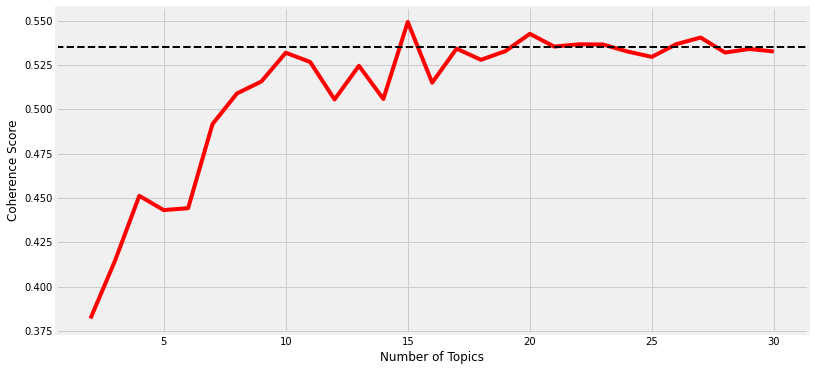

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

We choose the optimal number of topics as 15, based on our intuition. We can retrieve the best model now

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 15].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

15

In [76]:
best_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=15, id2word=dictionary,
                                              iterations=500, workers=4)

In [77]:
best_lda_model.num_topics

15

In [78]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['state', 'control', 'action', 'trajectory', 'step', 'policy', 'environment', 'controller', 'reinforcement_learning', 'optimal', 'robot', 'task', 'goal', 'dynamic', 'position', 'change', 'path', 'reward', 'movement', 'forward']

Topic #2:
['task', 'search', 'training', 'experiment', 'target', 'table', 'random', 'run', 'technique', 'test', 'region', 'expert', 'domain', 'trained', 'found', 'average', 'study', 'evaluation', 'good', 'important']

Topic #3:
['circuit', 'chip', 'current', 'neuron', 'analog', 'bit', 'voltage', 'signal', 'implementation', 'processor', 'design', 'neural', 'operation', 'computation', 'parallel', 'device', 'array', 'synapse', 'digital', 'element']

Topic #4:
['bound', 'class', 'theorem', 'probability', 'approximation', 'size', 'threshold', 'defined', 'theory', 'proof', 'polynomial', 'linear', 'xi', 'define', 'assume', 'definition', 'complexity', 'condition', 'property', 'constant']

Topic #5:
['noise', 'prediction', 'rate', 'gradient', 'linear', 'nonlin

# Viewing LDA Model topics

In [30]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Term1,cell,distribution,class,pattern,image,training,word,control,circuit,unit,neuron,rule,vector,state,equation
Term2,response,probability,bound,memory,object,prediction,classifier,trajectory,chip,node,signal,task,distance,action,dynamic
Term3,visual,gaussian,theorem,representation,feature,noise,classification,position,neuron,layer,cell,search,local,step,solution
Term4,motion,variable,size,target,pixel,training_set,training,dynamic,current,hidden_unit,spike,table,cluster,policy,matrix
Term5,unit,prior,linear,subject,view,average,class,controller,analog,net,frequency,experiment,matrix,reinforcement_learning,vector
Term6,stimulus,density,threshold,task,face,kernel,recognition,movement,voltage,activation,response,test,solution,transition,eq
Term7,map,mixture,theory,human,filter,estimate,speech,motor,bit,architecture,synaptic,instance,code,optimal,convergence
Term8,layer,estimate,approximation,structure,representation,regression,feature,signal,signal,training,activity,feature,map,environment,rate
Term9,receptive_field,bayesian,loss,capacity,region,linear,pattern,robot,implementation,pattern,firing,domain,dimension,sequence,gradient
Term10,spatial,approximation,probability,effect,surface,test,trained,hand,processor,recurrent,channel,technique,structure,task,energy


In [31]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"cell, response, visual, motion, unit, stimulus, map, layer, receptive_field, spatial, direction, activity, eye, orientation, cortical, center, pattern, contrast, neuron, cortex"
Topic2,"distribution, probability, gaussian, variable, prior, density, mixture, estimate, bayesian, approximation, sample, component, log, likelihood, source, estimation, em, posterior, entropy, variance"
Topic3,"class, bound, theorem, size, linear, threshold, theory, approximation, loss, probability, xi, proof, polynomial, complexity, defined, assume, define, distribution, definition, machine"
Topic4,"pattern, memory, representation, target, subject, task, human, structure, capacity, effect, component, similarity, level, study, location, trial, theory, cue, activity, brain"
Topic5,"image, object, feature, pixel, view, face, filter, representation, region, surface, shape, scale, part, edge, visual, location, contour, recognition, transformation, position"
Topic6,"training, prediction, noise, training_set, average, kernel, estimate, regression, linear, test, optimal, variance, nonlinear, ensemble, generalization, sample, procedure, generalization_error, effect, bias"
Topic7,"word, classifier, classification, training, class, recognition, speech, feature, pattern, trained, character, hmm, sequence, context, mlp, error_rate, speaker, experiment, letter, frame"
Topic8,"control, trajectory, position, dynamic, controller, movement, motor, signal, robot, hand, target, forward, adaptive, change, feedback, task, sensor, arm, architecture, mapping"
Topic9,"circuit, chip, neuron, current, analog, voltage, bit, signal, implementation, processor, design, neural, operation, computation, parallel, device, array, digital, connection, element"
Topic10,"unit, node, layer, hidden_unit, net, activation, architecture, training, pattern, recurrent, connection, sequence, back_propagation, trained, hidden_layer, structure, representation, connectionist, hidden, symbol"


# Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case).

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing.

In [32]:
print(bow_corpus[0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [33]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[0][:30]])

[('2m', 1), ('2r', 1), ('3a', 1), ('4a', 1), ('4b', 1), ('4c', 1), ('ability', 1), ('ac', 2), ('acad_sci', 1), ('according', 1), ('acknowledgement', 1), ('add', 1), ('adding', 2), ('addition', 2), ('additional', 1), ('advance', 1), ('affecting', 1), ('ai', 1), ('allow', 1), ('almost', 2), ('although', 1), ('always', 1), ('american_institute', 1), ('among', 1), ('analyzed', 1), ('another', 1), ('ap', 1), ('appear', 1), ('appears', 1), ('applicable', 1)]


In [34]:
tm_results = best_lda_model[bow_corpus] 

In [35]:
tm_results[0]

[(0, 0.017356475300400534),
 (1, 0.029075804776739357),
 (2, 0.1754932502596054),
 (3, 0.11096276516837265),
 (4, 0.025070464322800773),
 (5, 0.010087524106215698),
 (6, 0.007268951194184841),
 (7, 0.04776739356178609),
 (8, 0.12327547841566536),
 (9, 0.03322949117341642),
 (10, 0.022251891410769917),
 (11, 0.026108885921970033),
 (12, 0.06200860406467883),
 (13, 0.018988280670523657),
 (14, 0.2910547396528705)]

In [36]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(14, 0.2910547396528705),
 (14, 0.2867063492063492),
 (3, 0.27108585858585854),
 (10, 0.3829275623685002),
 (10, 0.6344153141905952)]

In [37]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = [paper[:500] for paper in papers]

# Dominant Topics in Specific Research Papers

Another interesting perspective is to select specific papers, view the most dominant topic
in each of those papers, and see if that makes sense.

In [38]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1041,1,70.98,"cell, response, visual, motion, unit, stimulus, map, layer, receptive_field, spatial, direction, activity, eye, orientation, cortical, center, pattern, contrast, neuron, cortex","A model of transparent motion and \nnon-transparent motion aftereffects \nAlexander Grunewald* \nMax-Planck Institut fiir biologische Kybernetik \nSpemannstral]e 38 \nD-72076 Tiibingen, Germany \nAbstract \nA model of human motion perception is presented. The model \ncontains two stages of direction selective units. The first stage con- \ntains broadly tuned units, while the second stage contains units \nthat are narrowly tuned. The model accounts for the motion af- \ntereffect through adapting units at th"
2,1724,2,65.55,"distribution, probability, gaussian, variable, prior, density, mixture, estimate, bayesian, approximation, sample, component, log, likelihood, source, estimation, em, posterior, entropy, variance","The Infinite Gaussian Mixture Model \nCarl Edward Rasmussen \nDepartment of Mathematical Modelling \nTechnical University of Denmark \nBuilding 321, DK-2800 Kongens Lyngby, Denmark \ncarl@imm.dtu.dk http://bayes.imm.dtu.dk \nAbstract \nIn a Bayesian mixture model it is not necessary a priori to limit the num- \nber of components to be finite. In this paper an infinite Gaussian mixture \nmodel is presented which neatly sidesteps the difficult problem of find- \ning the ""right"" number of mixture components."
3,522,3,84.16,"class, bound, theorem, size, linear, threshold, theory, approximation, loss, probability, xi, proof, polynomial, complexity, defined, assume, define, distribution, definition, machine","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversitk degli Studi di Milano \nvia Comelico, 39 - 20135 Milano- Italy \nAbstract \nWe define the concept of polynomial uniform convergence of relative \nfrequencies to probabilities in the distribution-dependent context. Let \nX = {0, 1} , let P be a probability distribution on X and let F C 2 x' \nbe a family"
4,314,4,60.23,"pattern, memory, representation, target, subject, task, human, structure, capacity, effect, component, similarity, level, study, location, trial, theory, cue, activity, brain","Direct memory access using two cues: Finding \nthe intersection of sets in a connectionist model \nJanet Wiles, Michael S. Humphreys, John D. Bain and Simon Dennis \nDepartments of Psychology and Computer Science \nUniversity of Queensland QLD 4072 Australia \nemail: j anetCWpsych.psy.uq.oz.au \nAbstract \nFor lack of alternative models, search and decision processes have provided the \ndominant paradigm for human memory access using two or more cues, despite \nevidence against search as an access proces"
5,544,5,61.81,"image, object, feature, pixel, view, face, filter, representation, region, surface, shape, scale, part, edge, visual, location, contour, recognition, transformation, position","Illumination and View Position in 3D Visual \nRecognition \nAmnon Shashua \nM.I.T. Artificial Intelligence Lab., NE43-737 \nand Department of Brain and Cognitive Science \nCambridge, MA 02139 \nAbstract \nIt is shown that both changes in viewing position and illumination con- \nditions can be compensated for, prior to recognition, using combinations \nof images taken from different viewing positions and different illumina- \ntion conditions. It is also shown that, in agreement with psychophysical \nfinding"
6,976,6,67.38,"training, prediction, noise, training_set, average, kernel, estimate, regression, linear, test, optimal, variance, nonlinear, ensemble, generalization, sample, procedure, generalization_error, effect, bias","Neural Network Ensembles, Cross \nValidation, and Active Learning \nAnders Krogh* \nNordita \nBlegdamsvej 17 \n2100 Copenhagen, Denmark \nJesper

# Inference on existing papers

In [39]:
sample_paper_patterns = ['Feudal Reinforcement Learning \nPeter', 'Illumination-Invariant Face Recognition with a', 'Improved Hidden Markov Model Speech Recognition']
sample_paper_idxs = [idx for pattern in sample_paper_patterns 
                            for idx, content in enumerate(papers) 
                                if pattern in content]
sample_paper_idxs

[622, 829, 440]

In [40]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin(sample_paper_idxs)])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
440,440,7,59.16,"word, classifier, classification, training, class, recognition, speech, feature, pattern, trained, character, hmm, sequence, context, mlp, error_rate, speaker, experiment, letter, frame","Improved Hidden Markov Model \nSpeech Recognition Using \nRadial Basis Function Networks \nElliot Singer and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108, USA \nAbstrac..."
622,622,14,47.71,"state, action, step, policy, reinforcement_learning, transition, optimal, environment, sequence, task, control, current, path, reward, stochastic, td, goal, trial, agent, probability","Feudal Reinforcement Learning \nPeter Dayan \nCNL \nThe Salk Institute \nPO Box 85800 \nSan Diego CA 92186-5800, USA \ndayanhelmholtz. sdsc. edu \nGeoffrey E Hinton \nDepartment of Computer Scien..."
829,829,5,35.76,"image, object, feature, pixel, view, face, filter, representation, region, surface, shape, scale, part, edge, visual, location, contour, recognition, transformation, position","Illumination-Invariant Face Recognition with a \nContrast Sensitive Silicon Retina \nJoachim M. Buhmann \nRheinische Friedrich-Wilhelms-Universitfit \nInstitut ftir Informatik II, R6merstrage 164 ..."


# Topic Inference on New Papers (Data)

In [41]:
new_paper = """
Unsupervised Translation of Programming Languages
Marie-Anne Lachaux, Baptiste Roziere, Lowik Chanussot, Guillaume Lample
A transcompiler, also known as source-to-source translator, is a system that converts source code 
from a high-level programming language (such as C++ or Python) to another. 
Transcompilers are primarily used for interoperability, and to port codebases 
written in an obsolete or deprecated language (e.g. COBOL, Python 2) to a modern one. 
They typically rely on handcrafted rewrite rules, applied to the source code abstract syntax tree. 
Unfortunately, the resulting translations often lack readability, fail to respect the target language conventions, 
and require manual modifications in order to work properly. 
The overall translation process is timeconsuming and requires expertise in both the source and target languages, 
making code-translation projects expensive. 
Although neural models significantly outperform their rule-based counterparts in the context of natural language translation, 
their applications to transcompilation have been limited due to the scarcity of parallel data in this domain. 
In this paper, we propose to leverage recent approaches in unsupervised machine translation to train a fully 
unsupervised neural transcompiler. We train our model on source code from open source GitHub projects, 
and show that it can translate functions between C++, Java, and Python with high accuracy. 
Our method relies exclusively on monolingual source code, requires no expertise in the source or target languages, 
and can easily be generalized to other programming languages. We also build and release a test set composed of 852 
parallel functions, along with unit tests to check the correctness of translations. 
We show that our model outperforms rule-based commercial baselines by a significant margin.
"""

new_paper

'\nUnsupervised Translation of Programming Languages\nMarie-Anne Lachaux, Baptiste Roziere, Lowik Chanussot, Guillaume Lample\nA transcompiler, also known as source-to-source translator, is a system that converts source code \nfrom a high-level programming language (such as C++ or Python) to another. \nTranscompilers are primarily used for interoperability, and to port codebases \nwritten in an obsolete or deprecated language (e.g. COBOL, Python 2) to a modern one. \nThey typically rely on handcrafted rewrite rules, applied to the source code abstract syntax tree. \nUnfortunately, the resulting translations often lack readability, fail to respect the target language conventions, \nand require manual modifications in order to work properly. \nThe overall translation process is timeconsuming and requires expertise in both the source and target languages, \nmaking code-translation projects expensive. \nAlthough neural models significantly outperform their rule-based counterparts in the co

## Pre-process Text

In [42]:
preprocessed_papers = normalize_corpus([new_paper])
print(preprocessed_papers[0][:30])

100%|██████████| 1/1 [00:00<00:00, 214.26it/s]

['unsupervised', 'translation', 'programming', 'language', 'marie', 'anne', 'lachaux', 'baptiste', 'roziere', 'lowik', 'chanussot', 'guillaume', 'lample', 'transcompiler', 'also', 'known', 'source', 'source', 'translator', 'system', 'convert', 'source', 'code', 'high', 'level', 'programming', 'language', 'python', 'another', 'transcompilers']


## Generate Influential Bi-grams if any

In [43]:
bigrams_corpus = [bigram_model[doc] for doc in preprocessed_papers]
print(bigrams_corpus[0][90:100])

['rule', 'based', 'counterpart', 'context', 'natural_language', 'translation', 'application', 'transcompilation', 'limited', 'due']


## Generate BOW Vectors from Training Vectorizer

In [44]:
bow_corpus = [dictionary.doc2bow(text) for text in bigrams_corpus]
print(bow_corpus[0][:30])

[(20, 1), (25, 1), (84, 1), (134, 1), (138, 1), (200, 2), (256, 1), (285, 2), (329, 1), (351, 1), (353, 1), (407, 1), (422, 1), (425, 1), (471, 1), (531, 1), (575, 1), (576, 7), (636, 1), (651, 1), (722, 1), (742, 1), (858, 1), (865, 1), (899, 1), (903, 2), (942, 2), (964, 1), (1030, 1), (1051, 1)]


## Use trained topic model to predict topics

In [45]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[0][:30]])

[('although', 1), ('another', 1), ('composed', 1), ('domain', 1), ('easily', 1), ('high', 2), ('limited', 1), ('neural', 2), ('properly', 1), ('require', 1), ('resulting', 1), ('test', 1), ('typically', 1), ('unit', 1), ('applied', 1), ('due', 1), ('lack', 1), ('language', 7), ('recent', 1), ('rewrite', 1), ('abstract', 1), ('application', 1), ('known', 1), ('level', 1), ('open', 1), ('parallel', 2), ('requires', 2), ('significant', 1), ('accuracy', 1), ('along', 1)]


## Show most relevant topic

In [46]:
predicted_topics = best_lda_model[bow_corpus][0]
predicted_topics

[(0, 0.03516174402250352),
 (1, 0.06399437412095639),
 (2, 0.048523206751054856),
 (3, 0.059774964838255965),
 (4, 0.06962025316455693),
 (5, 0.03305203938115331),
 (6, 0.11884669479606189),
 (7, 0.043600562587904367),
 (8, 0.08579465541490855),
 (9, 0.07665260196905764),
 (10, 0.042897327707454296),
 (11, 0.15611814345991562),
 (12, 0.08438818565400841),
 (13, 0.04008438818565402),
 (14, 0.041490857946554154)]

In [47]:
top_topic = max(predicted_topics, key=lambda x: x[1])
top_topic

(11, 0.15611814345991562)

In [48]:
top_topic_idx = top_topic[0]
top_topic_idx

11

In [49]:
topics_df.iloc[[top_topic_idx]]

,Terms per Topic
Topic12,"rule, task, search, table, experiment, test, instance, feature, domain, technique, machine, training, application, user, query, accuracy, knowledge, measure, type, run"


In [50]:
print(new_paper)


Unsupervised Translation of Programming Languages
Marie-Anne Lachaux, Baptiste Roziere, Lowik Chanussot, Guillaume Lample
A transcompiler, also known as source-to-source translator, is a system that converts source code 
from a high-level programming language (such as C++ or Python) to another. 
Transcompilers are primarily used for interoperability, and to port codebases 
written in an obsolete or deprecated language (e.g. COBOL, Python 2) to a modern one. 
They typically rely on handcrafted rewrite rules, applied to the source code abstract syntax tree. 
Unfortunately, the resulting translations often lack readability, fail to respect the target language conventions, 
and require manual modifications in order to work properly. 
The overall translation process is timeconsuming and requires expertise in both the source and target languages, 
making code-translation projects expensive. 
Although neural models significantly outperform their rule-based counterparts in the context of natu